In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-09 00:18:30--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.133.128, 16.182.99.160, 52.217.98.222, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.8MB/s    in 0.9s    

2024-04-09 00:18:31 (14.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
#Paring the data-converting the comma-seperated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis
import numpy as np
temperature = np.zeros((len(lines),))
rawdata = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    rawdata[i, :] = values[:]

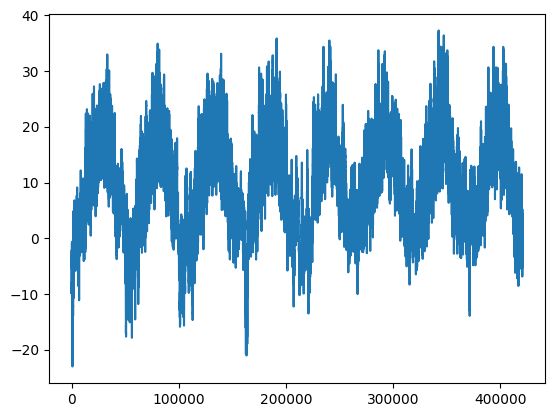

In [4]:

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

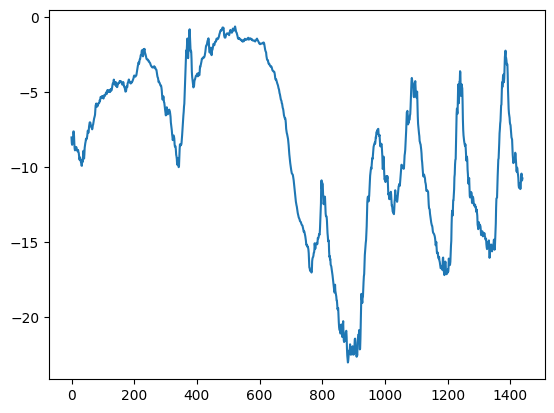

In [5]:

plt.plot(range(1440), temperature[:1440])

In [6]:

num_train_samples = int(0.5 * len(rawdata))
num_val_samples = int(0.25 * len(rawdata))
num_test_samples = len(rawdata) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:

mean = rawdata[:num_train_samples].mean(axis=0)
rawdata -= mean
std = rawdata[:num_train_samples].std(axis=0)
rawdata /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
#Initializing datasets is necessary for testing, validation, and training because the dataset's samples are largely redundant. Thus, explicitly allocating memory for every sample would be inefficient.Rather, we will produce the samples in real time.

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    rawdata[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
#Inspecting the output of one of our datasets
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.
def evaluate_naive_method(dataset):
    total_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

#A sensible baseline approach would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the simple baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average deviation of roughly 2.5 degrees would arise from assuming that the future temperature stays constant with the current temperature.

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
#A basic machine-learning model - Dense Layer
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 13s 14ms/step - loss: 12.2302 - mae: 2.7064 - val_loss: 10.3553 - val_mae: 2.5408
Epoch 2/5
819/819 [==============================] - 11s 14ms/step - loss: 9.0125 - mae: 2.3643 - val_loss: 11.6985 - val_mae: 2.6999
Epoch 3/5
819/819 [==============================] - 11s 14ms/step - loss: 8.3582 - mae: 2.2798 - val_loss: 10.4268 - val_mae: 2.5467
Epoch 4/5
819/819 [==============================] - 11s 14ms/step - loss: 7.8819 - mae: 2.2149 - val_loss: 12.9009 - val_mae: 2.8536
Epoch 5/5
405/405 [==============================] - 4s 10ms/step - loss: 11.5341 - mae: 2.6660
Test MAE: 2.67


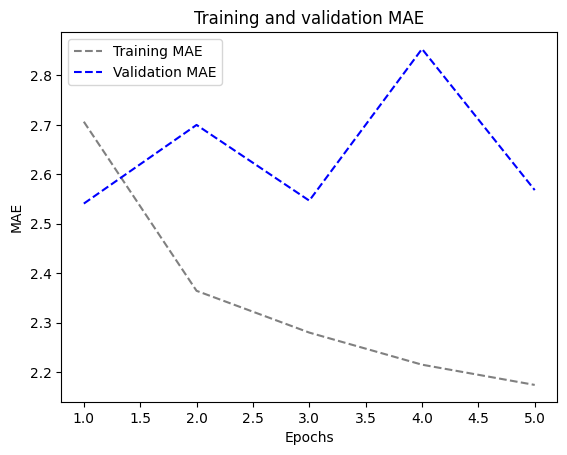

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [15]:
 #1D Convolutional Model
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 14ms/step - loss: 25.5190 - mae: 3.9082 - val_loss: 14.6143 - val_mae: 2.9968
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 16.2204 - mae: 3.1962 - val_loss: 14.4498 - val_mae: 2.9876
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.7010 - mae: 3.0430 - val_loss: 15.0749 - val_mae: 3.0666
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 13.7464 - mae: 2.9355 - val_loss: 16.0352 - val_mae: 3.1661
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 13.0280 - mae: 2.8543 - val_loss: 15.1608 - val_mae: 3.0692
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 12.4768 - mae: 2.7904 - val_loss: 15.8156 - val_mae: 3.1601
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 12.0621 - mae: 2.7424 - val_loss: 15.3488 - val_mae: 3.0829
Epoch 8/10
819/819 [============================

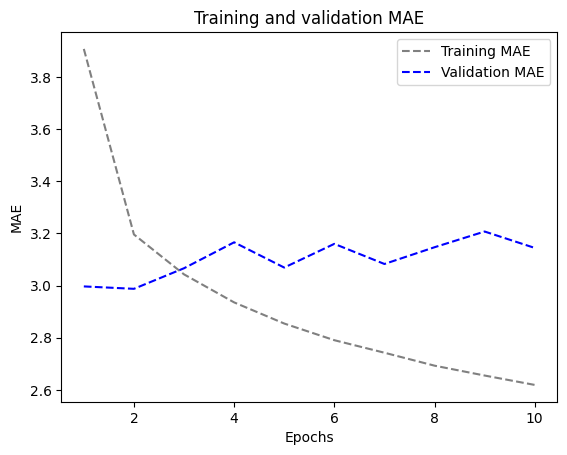

In [16]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [17]:
#Comprehension of Recurrent Neural Nets
#An RNN implementation in NumPy
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [18]:
#An RNN layer in Keras that can handle sequences of any length
#A recurrent layer
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [19]:
#RNN
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 13s 14ms/step - loss: 14.7792 - mae: 3.0478 - val_loss: 15.1042 - val_mae: 3.0840
Epoch 2/5
819/819 [==============================] - 11s 14ms/step - loss: 13.7791 - mae: 2.9417 - val_loss: 16.5505 - val_mae: 3.2393
Epoch 3/5
819/819 [==============================] - 12s 14ms/step - loss: 13.0584 - mae: 2.8584 - val_loss: 17.5440 - val_mae: 3.3281
Epoch 4/5
819/819 [==============================] - 12s 14ms/step - loss: 12.5101 - mae: 2.7947 - val_loss: 19.2223 - val_mae: 3.4605
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 17.2196 - mae: 3.3321
Test MAE: 3.33


In [20]:
#Basic RNN featuring stacked layers
from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 188s 227ms/step - loss: 137.2022 - mae: 9.5803 - val_loss: 143.4491 - val_mae: 9.8417
Epoch 2/5
819/819 [==============================] - 185s 225ms/step - loss: 135.9564 - mae: 9.5148 - val_loss: 143.3858 - val_mae: 9.8329
Epoch 3/5
819/819 [==============================] - 185s 225ms/step - loss: 135.8950 - mae: 9.5058 - val_loss: 143.4471 - val_mae: 9.8435
Epoch 4/5
819/819 [==============================] - 186s 227ms/step - loss: 135.8543 - mae: 9.5002 - val_loss: 143.4767 - val_mae: 9.8470
Epoch 5/5
405/405 [==============================] - 13s 31ms/step - loss: 151.1246 - mae: 9.9038
Test MAE: 9.90


In [21]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked_1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 189s 228ms/step - loss: 136.4104 - mae: 9.5418 - val_loss: 143.4894 - val_mae: 9.8467
Epoch 2/5
819/819 [==============================] - 186s 226ms/step - loss: 135.8960 - mae: 9.5054 - val_loss: 143.3962 - val_mae: 9.8372
Epoch 3/5
819/819 [==============================] - 187s 228ms/step - loss: 135.8433 - mae: 9.4977 - val_loss: 143.3843 - val_mae: 9.8331
Epoch 4/5
819/819 [==============================] - 185s 226ms/step - loss: 135.8132 - mae: 9.4929 - val_loss: 143.3895 - val_mae: 9.8331
Epoch 5/5
405/405 [==============================] - 13s 30ms/step - loss: 151.1192 - mae: 9.9008
Test MAE: 9.90


In [22]:
# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# GRU layer
x = layers.GRU(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 15ms/step - loss: 41.5387 - mae: 4.6872 - val_loss: 13.4081 - val_mae: 2.7677
Epoch 2/5
819/819 [==============================] - 12s 14ms/step - loss: 10.9213 - mae: 2.5754 - val_loss: 9.7392 - val_mae: 2.4128
Epoch 3/5
819/819 [==============================] - 12s 14ms/step - loss: 9.8657 - mae: 2.4599 - val_loss: 9.4036 - val_mae: 2.3793
Epoch 4/5
819/819 [==============================] - 12s 14ms/step - loss: 9.4628 - mae: 2.4083 - val_loss: 10.0423 - val_mae: 2.4231
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 10.2764 - mae: 2.5107
Test MAE: 2.51


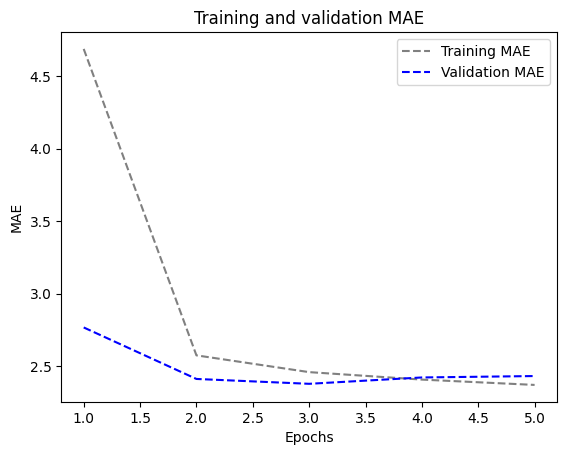

In [23]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [24]:
# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 15ms/step - loss: 43.1821 - mae: 4.7929 - val_loss: 12.9170 - val_mae: 2.7273
Epoch 2/5
819/819 [==============================] - 12s 14ms/step - loss: 11.1008 - mae: 2.5894 - val_loss: 9.8242 - val_mae: 2.4450
Epoch 3/5
819/819 [==============================] - 12s 15ms/step - loss: 10.0360 - mae: 2.4708 - val_loss: 9.6375 - val_mae: 2.4153
Epoch 4/5
819/819 [==============================] - 12s 14ms/step - loss: 9.6245 - mae: 2.4201 - val_loss: 9.7302 - val_mae: 2.4329
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 10.6472 - mae: 2.5528
Test MAE: 2.55


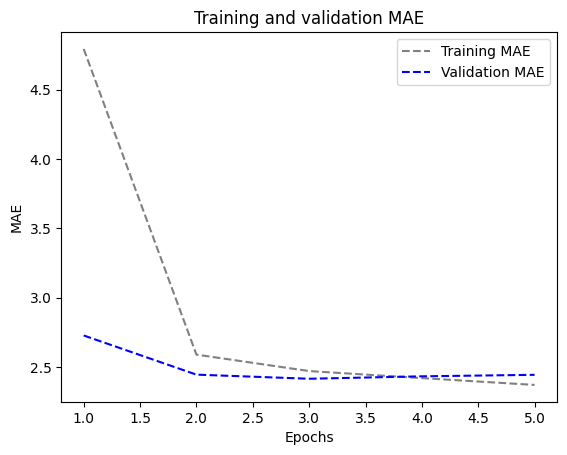

In [25]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [26]:
# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
#Dropout layer
x = layers.Dropout(0.5)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 14s 14ms/step - loss: 43.7853 - mae: 4.9211 - val_loss: 13.0640 - val_mae: 2.7129
Epoch 2/5
819/819 [==============================] - 12s 14ms/step - loss: 19.4906 - mae: 3.3912 - val_loss: 9.9682 - val_mae: 2.4509
Epoch 3/5
819/819 [==============================] - 12s 14ms/step - loss: 17.7373 - mae: 3.2384 - val_loss: 9.5357 - val_mae: 2.4032
Epoch 4/5
819/819 [==============================] - 12s 14ms/step - loss: 16.8838 - mae: 3.1584 - val_loss: 9.4706 - val_mae: 2.3975
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 10.3873 - mae: 2.5146
Test MAE: 2.51


In [27]:
# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# LSTM stacked layer
x = layers.LSTM(16,return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_1.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 18s 19ms/step - loss: 40.1329 - mae: 4.6281 - val_loss: 12.6304 - val_mae: 2.6897
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 10.4929 - mae: 2.5141 - val_loss: 9.6439 - val_mae: 2.4011
Epoch 3/5
819/819 [==============================] - 14s 18ms/step - loss: 9.0082 - mae: 2.3427 - val_loss: 9.5575 - val_mae: 2.4016
Epoch 4/5
819/819 [==============================] - 14s 17ms/step - loss: 8.3486 - mae: 2.2593 - val_loss: 10.2571 - val_mae: 2.4894
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 10.9292 - mae: 2.5837
Test MAE: 2.58


In [28]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# LSTM layer
x = layers.LSTM(32,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(32)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_2.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 17s 18ms/step - loss: 20.5138 - mae: 3.2432 - val_loss: 10.2849 - val_mae: 2.4976
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 7.7084 - mae: 2.1587 - val_loss: 11.3200 - val_mae: 2.6416
Epoch 3/5
819/819 [==============================] - 14s 18ms/step - loss: 6.3631 - mae: 1.9561 - val_loss: 12.3242 - val_mae: 2.7629
Epoch 4/5
819/819 [==============================] - 14s 18ms/step - loss: 5.4684 - mae: 1.8060 - val_loss: 12.3384 - val_mae: 2.7732
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 11.7372 - mae: 2.6973
Test MAE: 2.70


In [29]:
#input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
# LSTM layer
x = layers.LSTM(8,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_3.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 17s 18ms/step - loss: 75.3408 - mae: 6.6909 - val_loss: 39.0513 - val_mae: 4.6856
Epoch 2/5
819/819 [==============================] - 14s 17ms/step - loss: 23.3055 - mae: 3.5824 - val_loss: 14.2596 - val_mae: 2.8397
Epoch 3/5
819/819 [==============================] - 14s 18ms/step - loss: 11.8728 - mae: 2.6704 - val_loss: 10.9114 - val_mae: 2.5291
Epoch 4/5
819/819 [==============================] - 14s 17ms/step - loss: 10.3413 - mae: 2.5136 - val_loss: 9.9880 - val_mae: 2.4556
Epoch 5/5
405/405 [==============================] - 6s 10ms/step - loss: 10.7240 - mae: 2.5532
Test MAE: 2.55


In [30]:
from tensorflow import keras
from tensorflow.keras import layers

# input layer
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))

# stacked layers
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 17s 18ms/step - loss: 74.9615 - mae: 6.6272 - val_loss: 40.2466 - val_mae: 4.6909
Epoch 2/5
819/819 [==============================] - 14s 18ms/step - loss: 23.0521 - mae: 3.4987 - val_loss: 13.8119 - val_mae: 2.7658
Epoch 3/5
819/819 [==============================] - 14s 17ms/step - loss: 10.9390 - mae: 2.5355 - val_loss: 10.0392 - val_mae: 2.4479
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 9.2792 - mae: 2.3646 - val_loss: 9.5719 - val_mae: 2.4061
Epoch 5/5
405/405 [==============================] - 5s 11ms/step - loss: 11.5178 - mae: 2.6581
Test MAE: 2.66


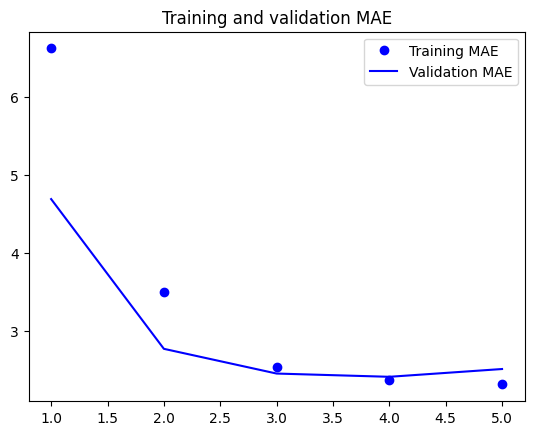

In [31]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [32]:
#lstm droput
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 416s 503ms/step - loss: 71.9758 - mae: 6.5107 - val_loss: 32.9756 - val_mae: 4.2492
Epoch 2/5
819/819 [==============================] - 416s 508ms/step - loss: 31.0196 - mae: 4.1647 - val_loss: 13.4230 - val_mae: 2.7348
Epoch 3/5
819/819 [==============================] - 417s 509ms/step - loss: 24.2098 - mae: 3.7304 - val_loss: 11.1036 - val_mae: 2.5432
Epoch 4/5
819/819 [==============================] - 419s 511ms/step - loss: 22.4829 - mae: 3.6009 - val_loss: 10.6663 - val_mae: 2.5203
Epoch 5/5
819/819 [==============================] - 423s 516ms/step - loss: 21.1308 - mae: 3.4909 - val_loss: 9.9565 - val_mae: 2.4423


405/405 [==============================] - 29s 70ms/step - loss: 11.3764 - mae: 2.6056
Test MAE: 2.61


In [33]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

In [34]:
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset)

Epoch 1/5
819/819 [==============================] - 18s 18ms/step - loss: 26.3492 - mae: 3.6869 - val_loss: 10.3311 - val_mae: 2.4853
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 9.5071 - mae: 2.4109 - val_loss: 9.5682 - val_mae: 2.3912
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 8.6186 - mae: 2.2876 - val_loss: 9.5441 - val_mae: 2.3898
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 8.0756 - mae: 2.2135 - val_loss: 10.2604 - val_mae: 2.4697
Epoch 5/5
819/819 [==============================] - 16s 19ms/step - loss: 7.7106 - mae: 2.1612 - val_loss: 10.0620 - val_mae: 2.4574


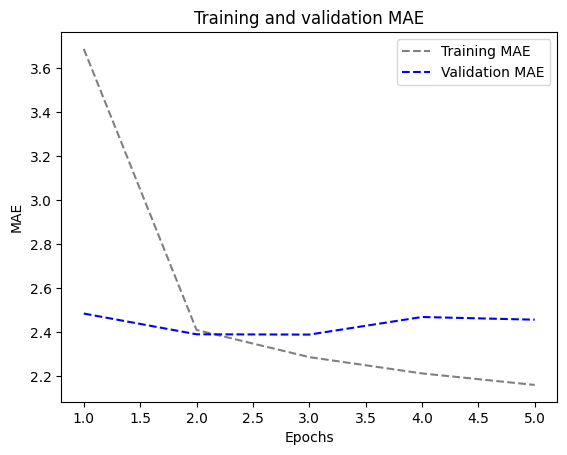

In [35]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [36]:
#1D convents and LSTM together
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, rawdata.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 15s 15ms/step - loss: 56.7251 - mae: 5.6662 - val_loss: 29.2850 - val_mae: 4.1534
Epoch 2/5
819/819 [==============================] - 12s 15ms/step - loss: 18.7140 - mae: 3.3224 - val_loss: 22.0800 - val_mae: 3.6980
Epoch 3/5
819/819 [==============================] - 12s 15ms/step - loss: 14.7188 - mae: 2.9747 - val_loss: 23.4567 - val_mae: 3.8042
Epoch 4/5
819/819 [==============================] - 12s 15ms/step - loss: 13.0413 - mae: 2.7941 - val_loss: 22.6736 - val_mae: 3.7951
Epoch 5/5
405/405 [==============================] - 5s 10ms/step - loss: 24.5977 - mae: 3.9305
Test MAE: 3.93


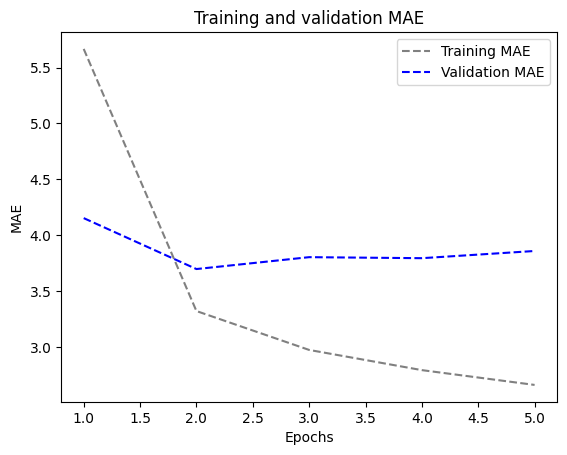

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()